**Note:  this notebook came from [Abhey Shukla](https://github.com/silpara), in his [simulators](https://github.com/silpara/simulators) repo**

It needs plotly, lmfit, psutils, orca.

NP June 1 2020:  this version skips plotl, psutils, orca to use only matplotlib.pyplot


# Simulation & Parameter Estimation of SEIRD Model

SEIRD is a type of compartmental models which are used in modelling of infectious disease using differential equations. These types of models divide the population into groups or compartments and the dynamics of these groups are expressed with the help of a system of differential equations.

These system of equations are parametrized which capture the mechanistic nature of the disease. For simulation, you select values of these parameters and the resulting curves simulate the behaviour by solving the set of equations. Finally the results are plotted in a graph to visually understand the effect of the parameters.

## SEIRD Model

For completeness the SEIR model is produced below:

<img src="images/seird_model.png">

$\displaystyle \frac{dS}{dt} = -\frac{\beta S I}{N}$<br><br>
$\displaystyle \frac{dE}{dt} = \frac{\beta S I}{N} - \sigma E$<br><br>
$\displaystyle \frac{dI}{dt} = \sigma E -  \gamma I - \mu I$<br><br>
$\displaystyle \frac{dR}{dt} = \gamma I$<br><br>
$\displaystyle \frac{dD}{dt} = \mu I$<br><br>
$N = S + E + I + R + D$<br><br>
Where,<br><br>
$\beta$ is infection rate or the rate of spread<br><br>
$\sigma$ is the incubation rate or the rate of latent individuals becoming infectious (average duration of incubation is $1/\sigma$)<br><br>
$\gamma$ is the recovery rate or mortality rate. If the duration of indection is D then $\gamma$ = 1/D<br><br>
$\mu$ is the mortality rate due to the disease

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import plotly.graph_objects as go
import plotly.io as pio
import requests
from lmfit import minimize, Parameters, Parameter, report_fit
pio.renderers.default = "notebook"
%matplotlib inline
plt.style.use('ggplot')

In [3]:
# Jupyter Specifics
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons

style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [4]:
def ode_model(z, t, beta, sigma, gamma, mu):
    """
    Reference https://www.idmod.org/docs/hiv/model-seir.html
    """
    S, E, I, R, D = z
    N = S + E + I + R + D
    dSdt = -beta*S*I/N
    dEdt = beta*S*I/N - sigma*E
    dIdt = sigma*E - gamma*I - mu*I
    dRdt = gamma*I
    dDdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

In [5]:
def ode_solver(t, initial_conditions, params):
    initE, initI, initR, initN, initD = initial_conditions
    beta, sigma, gamma, mu = params['beta'].value, params['sigma'].value, params['gamma'].value, params['mu'].value
    initS = initN - (initE + initI + initR + initD)
    res = odeint(ode_model, [initS, initE, initI, initR, initD], t, args=(beta, sigma, gamma, mu))
    return res

In [6]:
response = requests.get('https://api.rootnet.in/covid19-in/stats/history')
print('Request Success? {}'.format(response.status_code == 200))
covid_history = response.json()['data']

Request Success? True


In [7]:
keys = ['day', 'total', 'confirmedCasesIndian', 'confirmedCasesForeign', 'confirmedButLocationUnidentified',
        'discharged', 'deaths']
df_covid_history = pd.DataFrame([[d.get('day'), 
                                  d['summary'].get('total'), 
                                  d['summary'].get('confirmedCasesIndian'), 
                                  d['summary'].get('confirmedCasesForeign'),
                                  d['summary'].get('confirmedButLocationUnidentified'),
                                  d['summary'].get('discharged'), 
                                  d['summary'].get('deaths')] 
                                 for d in covid_history],
                    columns=keys)
df_covid_history = df_covid_history.sort_values(by='day')
df_covid_history['infected'] = df_covid_history['total'] - df_covid_history['discharged'] - df_covid_history['deaths']
df_covid_history['total_recovered_or_dead'] = df_covid_history['discharged'] + df_covid_history['deaths']

In [8]:
df_covid_history.head()

,day,total,confirmedCasesIndian,confirmedCasesForeign,confirmedButLocationUnidentified,discharged,deaths,infected,total_recovered_or_dead
0,2020-03-10,47,31,16,0,0,0,47,0
1,2020-03-11,60,44,16,0,0,0,60,0
2,2020-03-12,73,56,17,0,0,0,73,0
3,2020-03-13,82,65,17,0,10,2,70,12
4,2020-03-14,84,67,17,0,10,2,72,12


In [9]:
# ref: https://www.medrxiv.org/content/10.1101/2020.04.01.20049825v1.full.pdf
initN = 1380000000
# S0 = 966000000
initE = 1000
initI = 47
initR = 0
initD = 0
sigma = 1/5.2
gamma = 1/2.9
mu = 0.034
R0 = 4
beta = R0 * gamma
days = 112

params = Parameters()
params.add('beta', value=beta, min=0, max=10)
params.add('sigma', value=sigma, min=0, max=10)
params.add('gamma', value=gamma, min=0, max=10)
params.add('mu', value=mu, min=0, max=10)

## Simulation

In [12]:
def main(initE=initE, initI=initI, initR=initR, initD=initD, initN=initN, beta=beta, sigma=sigma, gamma=gamma, mu=mu, days=days, param_fitting=False):
    initial_conditions = [initE, initI, initR, initN, initD]
    params['beta'].value, params['sigma'].value,params['gamma'].value, params['mu'].value = [beta, sigma, gamma, mu]
    tspan = np.arange(0, days, 1)
    sol = ode_solver(tspan, initial_conditions, params)
    S, E, I, R, D = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3], sol[:, 4]
    
    # Create traces
    fig = plt.figure()
    myleg = []
    if not param_fitting:
        lab = 'Susceptible'
        myleg.append(lab)
        plt.plot(tspan, S, label=lab)
        lab='Exposed'
        myleg.append(lab)
        plt.plot(tspan, E, label=lab)
    lab ='Infected'
    myleg.append(lab)
    plt.plot(tspan, I, label=lab)
    lab = 'Recovered'
    myleg.append(lab)
    plt.plot(tspan, R, label=lab)
    lab = 'Death'
    myleg.append(lab)
    plt.plot(tspan, D, label=lab)

    if param_fitting:
        plt.plot(tspan,df_covid_history.infected,label="Infections Observed")
        fig.add_trace(go.Scatter(x=tspan, y=df_covid_history.infected, mode='lines+markers',\
                             name='Infections Observed', line = dict(dash='dash')))
        fig.add_trace(go.Scatter(x=tspan, y=df_covid_history.discharged, mode='lines+markers',\
                             name='Recovered Observed', line = dict(dash='dash')))
        fig.add_trace(go.Scatter(x=tspan, y=df_covid_history.deaths, mode='lines+markers',\
                             name='Deaths Observed', line = dict(dash='dash')))
    
    if days <= 30:
        step = 1
    elif days <= 90:
        step = 7
    else:
        step = 30
    
    # Edit the layout
    plt.xlabel('Day')
    plt.ylabel('Counts')
    plt.legend(myleg)
    plt.show()

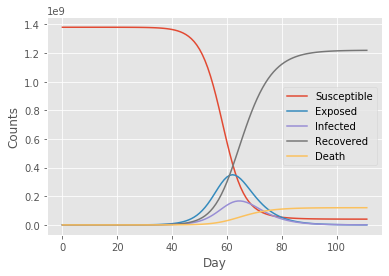

In [13]:
main()

In [10]:
def main_(initE, initI, initR, initD, initN, beta, sigma, gamma, mu, days, param_fitting):
    initial_conditions = [initE, initI, initR, initN, initD]
    params['beta'].value, params['sigma'].value,params['gamma'].value, params['mu'].value = [beta, sigma, gamma, mu]
    tspan = np.arange(0, days, 1)
    sol = ode_solver(tspan, initial_conditions, params)
    S, E, I, R, D = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3], sol[:, 4]
    
    # Create traces
    fig = go.Figure()
    if not param_fitting:
        fig.add_trace(go.Scatter(x=tspan, y=S, mode='lines+markers', name='Susceptible'))
        fig.add_trace(go.Scatter(x=tspan, y=E, mode='lines+markers', name='Exposed'))
    fig.add_trace(go.Scatter(x=tspan, y=I, mode='lines+markers', name='Infected'))
    fig.add_trace(go.Scatter(x=tspan, y=R, mode='lines+markers',name='Recovered'))
    fig.add_trace(go.Scatter(x=tspan, y=D, mode='lines+markers',name='Death'))
    if param_fitting:
        fig.add_trace(go.Scatter(x=tspan, y=df_covid_history.infected, mode='lines+markers',\
                             name='Infections Observed', line = dict(dash='dash')))
        fig.add_trace(go.Scatter(x=tspan, y=df_covid_history.discharged, mode='lines+markers',\
                             name='Recovered Observed', line = dict(dash='dash')))
        fig.add_trace(go.Scatter(x=tspan, y=df_covid_history.deaths, mode='lines+markers',\
                             name='Deaths Observed', line = dict(dash='dash')))
    
    if days <= 30:
        step = 1
    elif days <= 90:
        step = 7
    else:
        step = 30
    
    # Edit the layout
    fig.update_layout(title='Simulation of SEIRD Model',
                       xaxis_title='Day',
                       yaxis_title='Counts',
                       title_x=0.5,
                      width=900, height=600
                     )
    fig.update_xaxes(tickangle=-90, tickformat = None, tickmode='array', tickvals=np.arange(0, days + 1, step))
    if not os.path.exists("images"):
        os.mkdir("images")
    fig.write_image("images/seird_simulation.png")
    fig.show()

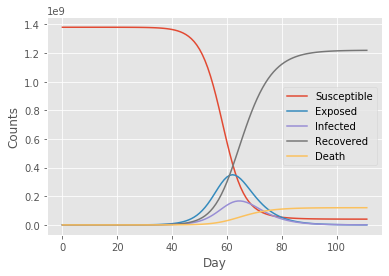

In [16]:
main()

interactive(children=(IntSlider(value=1000, description='initE', layout=Layout(width='99%'), max=100000, style…

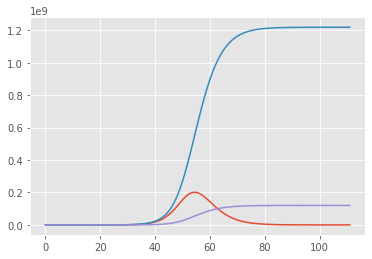

In [15]:
interact(main, 
         initE=IntSlider(min=0, max=100000, step=1, value=initE, description='initE', style=style, layout=slider_layout),
         initI=IntSlider(min=0, max=100000, step=10, value=initI, description='initI', style=style, layout=slider_layout),
         initR=IntSlider(min=0, max=100000, step=10, value=initR, description='initR', style=style, layout=slider_layout),
         initD=IntSlider(min=0, max=100000, step=10, value=initD, description='initD', style=style, layout=slider_layout),
         initN=IntSlider(min=0, max=1380000000, step=1000, value=initN, description='initN', style=style, layout=slider_layout),
         beta=FloatSlider(min=0, max=4, step=0.01, value=beta, description='Infection rate', style=style, layout=slider_layout),
         sigma=FloatSlider(min=0, max=4, step=0.01, value=sigma, description='Incubation rate', style=style, layout=slider_layout),
         gamma=FloatSlider(min=0, max=4, step=0.01, value=gamma, description='Recovery rate', style=style, layout=slider_layout),
         mu=FloatSlider(min=0, max=1, step=0.001, value=mu, description='Mortality rate', style=style, layout=slider_layout),
         days=IntSlider(min=0, max=600, step=7, value=days, description='Days', style=style, layout=slider_layout),
         param_fitting=ToggleButton(value=False, description='Fitting Mode', disabled=False, button_style='', \
             tooltip='Click to show fewer plots', icon='check-circle')
        );

## Parameter Estimation

In [24]:
def error(params, initial_conditions, tspan, data):
    sol = ode_solver(tspan, initial_conditions, params)
    return (sol[:, 2:5] - data).ravel()

In [25]:
initial_conditions = [initE, initI, initR, initN, initD]
beta = 1.14
sigma = 0.02
gamma = 0.02
mu = 0.01
params['beta'].value = beta
params['sigma'].value = sigma
params['gamma'].value = gamma
params['mu'].value = mu
days = 45
tspan = np.arange(0, days, 1)
data = df_covid_history.loc[0:(days-1), ['infected', 'discharged', 'deaths']].values

In [26]:
data.shape

(45, 3)

In [27]:
params

name,value,initial value,min,max,vary
beta,1.14000000,1.3793103448275863,0.00000000,10.0000000,True
sigma,0.02000000,0.1923076923076923,0.00000000,10.0000000,True
gamma,0.02000000,0.3448275862068966,0.00000000,10.0000000,True
mu,0.01000000,0.034,0.00000000,10.0000000,True


In [28]:
# fit model and find predicted values
result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')
# result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq', \
# **{'xtol':1.e-15, 'ftol':1.e-15})

In [29]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
beta,0.25012193,0.01967139,(7.86%),1.14,0.00000000,10.0000000,True
sigma,0.07995170,0.00717541,(8.97%),0.02,0.00000000,10.0000000,True
gamma,0.01816017,0.00102423,(5.64%),0.02,0.00000000,10.0000000,True
mu,0.00378277,9.6475e-04,(25.50%),0.01,0.00000000,10.0000000,True


In [30]:
# display fitted statistics
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 135
    # variables        = 4
    chi-square         = 25872760.4
    reduced chi-square = 197501.988
    Akaike info crit   = 1650.06257
    Bayesian info crit = 1661.68367
[[Variables]]
    beta:   0.25012193 +/- 0.01967139 (7.86%) (init = 1.14)
    sigma:  0.07995170 +/- 0.00717541 (8.97%) (init = 0.02)
    gamma:  0.01816017 +/- 0.00102423 (5.64%) (init = 0.02)
    mu:     0.00378277 +/- 9.6475e-04 (25.50%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, sigma)  = -0.983
    C(beta, gamma)  =  0.383
    C(sigma, gamma) = -0.270
    C(beta, mu)     =  0.143


In [43]:
final = data + result.residual.reshape(data.shape)

fig = go.Figure()
fig.add_trace(go.Scatter(x=tspan, y=data[:, 0], mode='markers', name='Observed Infections', line = dict(dash='dot')))
fig.add_trace(go.Scatter(x=tspan, y=data[:, 1], mode='markers', name='Observed Recovered', line = dict(dash='dot')))
fig.add_trace(go.Scatter(x=tspan, y=data[:, 2], mode='markers', name='Observed Deaths', line = dict(dash='dot')))
fig.add_trace(go.Scatter(x=tspan, y=final[:, 0], mode='lines+markers', name='Fitted Infections'))
fig.add_trace(go.Scatter(x=tspan, y=final[:, 1], mode='lines+markers', name='Fitted Recovered'))
fig.add_trace(go.Scatter(x=tspan, y=final[:, 2], mode='lines+markers', name='Fitted Deaths'))
fig.update_layout(title='SEIRD: Observed vs Fitted',
                       xaxis_title='Day',
                       yaxis_title='Counts',
                       title_x=0.5,
                      width=1000, height=600
                     )

In [35]:
observed_IRD = df_covid_history.loc[:, ['infected', 'discharged', 'deaths']].values
print(observed_IRD.shape)

(48, 3)


In [36]:
tspan_fit_pred = np.arange(0, observed_IRD.shape[0], 1)
params['beta'].value = result.params['beta'].value
params['sigma'].value = result.params['sigma'].value
params['gamma'].value = result.params['gamma'].value
params['mu'].value = result.params['mu'].value
fitted_predicted = ode_solver(tspan_fit_pred, initial_conditions, params)

In [37]:
fitted_predicted_IRD = fitted_predicted[:, 2:5]
print(fitted_predicted_IRD.shape)

(48, 3)


In [38]:
print("Fitted MAE")
print('Infected: ', np.mean(np.abs(fitted_predicted_IRD[:days, 0] - observed_IRD[:days, 0])))
print('Recovered: ', np.mean(np.abs(fitted_predicted_IRD[:days, 1] - observed_IRD[:days, 1])))
print('Dead: ', np.mean(np.abs(fitted_predicted_IRD[:days, 2] - observed_IRD[:days, 2])))

print("\nFitted RMSE")
print('Infected: ', np.sqrt(np.mean((fitted_predicted_IRD[:days, 0] - observed_IRD[:days, 0])**2)))
print('Recovered: ', np.sqrt(np.mean((fitted_predicted_IRD[:days, 1] - observed_IRD[:days, 1])**2)))
print('Dead: ', np.sqrt(np.mean((fitted_predicted_IRD[:days, 2] - observed_IRD[:days, 2])**2)))

Fitted MAE
Infected:  587.5587793520101
Recovered:  216.5347633701369
Dead:  21.532532235433454

Fitted RMSE
Infected:  702.1643902204037
Recovered:  284.9841911847741
Dead:  26.4463792416788


In [39]:
print("Predicted MAE")
print('Infected: ', np.mean(np.abs(fitted_predicted_IRD[days:observed_IRD.shape[0], 0] - observed_IRD[days:, 0])))
print('Recovered: ', np.mean(np.abs(fitted_predicted_IRD[days:observed_IRD.shape[0], 1] - observed_IRD[days:, 1])))
print('Dead: ', np.mean(np.abs(fitted_predicted_IRD[days:observed_IRD.shape[0], 2] - observed_IRD[days:, 2])))

print("\nPredicted RMSE")
print('Infected: ', np.sqrt(np.mean((fitted_predicted_IRD[days:observed_IRD.shape[0], 0] - observed_IRD[days:, 0])**2)))
print('Recovered: ', np.sqrt(np.mean((fitted_predicted_IRD[days:observed_IRD.shape[0], 1] - observed_IRD[days:, 1])**2)))
print('Dead: ', np.sqrt(np.mean((fitted_predicted_IRD[days:observed_IRD.shape[0], 2] - observed_IRD[days:, 2])**2)))

Predicted MAE
Infected:  3467.935464895652
Recovered:  1024.9276874384093
Dead:  117.13820975700246

Predicted RMSE
Infected:  3556.5050027558914
Recovered:  1033.452662364444
Dead:  120.34147562618548


In [40]:
interact(main, 
         initE=IntSlider(min=0, max=100000, step=1, value=initE, description='initE', style=style, layout=slider_layout),
         initI=IntSlider(min=0, max=100000, step=10, value=initI, description='initI', style=style, layout=slider_layout),
         initR=IntSlider(min=0, max=100000, step=10, value=initR, description='initR', style=style, layout=slider_layout),
         initD=IntSlider(min=0, max=100000, step=10, value=initD, description='initD', style=style, layout=slider_layout),
         initN=IntSlider(min=0, max=1380000000, step=1000, value=initN, description='initN', style=style, layout=slider_layout),
         beta=FloatSlider(min=0, max=4, step=0.01, value=result.params['beta'].value, description='Infection rate', style=style, layout=slider_layout),
         sigma=FloatSlider(min=0, max=4, step=0.01, value=result.params['sigma'].value, description='Incubation rate', style=style, layout=slider_layout),
         gamma=FloatSlider(min=0, max=4, step=0.01, value=result.params['gamma'].value, description='Recovery rate', style=style, layout=slider_layout),
         mu=FloatSlider(min=0, max=1, step=0.01, value=result.params['mu'].value, description='Mortality rate', style=style, layout=slider_layout),
         days=IntSlider(min=1, max=600, step=7, value=240, description='Days', style=style, layout=slider_layout),
         param_fitting=ToggleButton(value=False, description='Fitting Mode', disabled=True, button_style='', \
             tooltip='Click to show fewer plots', icon='check-circle')
        );

interactive(children=(IntSlider(value=1000, description='initE', layout=Layout(width='99%'), max=100000, style…

**References:**<br>
1. SEIR and SEIRS Model https://www.idmod.org/docs/hiv/model-seir.html<br>
2. Compartmental models in epidemiology https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model<br>
3. Solve Differential Equations in Python https://www.youtube.com/watch?v=VV3BnroVjZo<br>
4. Computational Statistics in Python https://people.duke.edu/~ccc14/sta-663/CalibratingODEs.html<br>
5. Ordinary Differential Equations (ODE) with Python and Jupyter https://elc.github.io/posts/ordinary-differential-equations-with-python/<br>
6. SEIRS+ Model https://github.com/ryansmcgee/seirsplus<br>
7. Stack Overflow https://stackoverflow.com/questions/40753159/why-is-scipy-minimize-ignoring-my-constraints<br>
8. Lotka–Volterra equations https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations<br>
9. SEIR and Regression Model based COVID-19 outbreak predictions in India https://www.medrxiv.org/content/10.1101/2020.04.01.20049825v1.full.pdf<br>

A simulator built with RShiny which provides many more parameters https://alhill.shinyapps.io/COVID19seir/